# Config

In [29]:
import torch
import numpy as np

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import mdtraj as md
import nglview as nv

In [5]:
def compute_dihedral(positions):
	"""http://stackoverflow.com/q/20305272/1128289"""
	def dihedral(p):
		if not isinstance(p, np.ndarray):
			p = p.numpy()
		b = p[:-1] - p[1:]
		b[0] *= -1
		v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
		
		# Normalize vectors
		v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
		b1 = b[1] / np.linalg.norm(b[1])
		x = np.dot(v[0], v[1])
		m = np.cross(v[0], b1)
		y = np.dot(m, v[1])
		
		return np.arctan2(y, x)

	angles = np.array(list(map(dihedral, positions)))
	return angles

In [61]:
state = "c5"
molecule = "alanine"
temperature = "300.0"
version = "timelag-10n-v1"

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]

# Basics

In [13]:
phi = np.load(f"../dataset/{molecule}/{temperature}/{version}/phi.npy")
psi = np.load(f"../dataset/{molecule}/{temperature}/{version}/psi.npy")
print(phi.shape, psi.shape)

(10000,) (10000,)


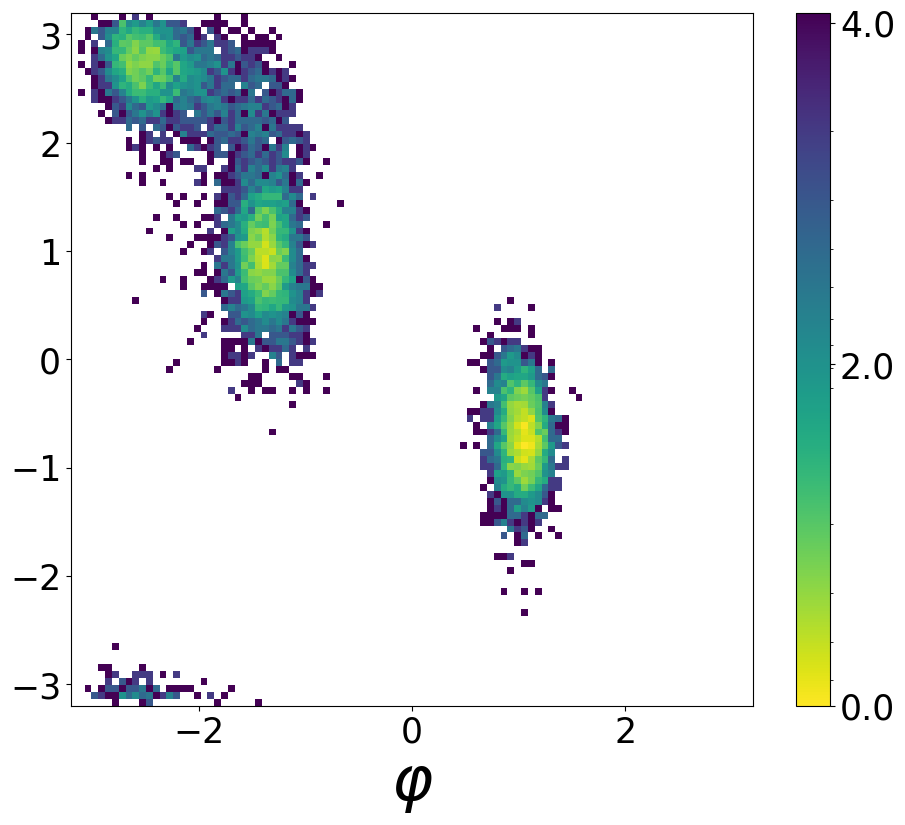

In [ ]:
fig, ax = plt.subplots(figsize=(11, 9))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel(r"$\varphi$", fontsize=45)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=25)
cbar.ax.invert_yaxis()

# Heavy atom xyz

In [19]:
xyz_aligned = torch.load(f"../dataset/{molecule}/{temperature}/{version}/xyz-aligned.pt")
xyz_aligned_timelag = torch.load(f"../dataset/{molecule}/{temperature}/{version}/xyz-aligned-timelag.pt")
print(xyz_aligned.shape, xyz_aligned_timelag.shape)

torch.Size([10000, 22, 3]) torch.Size([10000, 22, 3])


In [21]:
phi = compute_dihedral(xyz_aligned[:, PHI_ANGLE])
psi = compute_dihedral(xyz_aligned[:, PSI_ANGLE])
phi_timelag = compute_dihedral(xyz_aligned_timelag[:, PHI_ANGLE])
psi_timelag = compute_dihedral(xyz_aligned_timelag[:, PSI_ANGLE])
print(phi.shape, psi.shape, phi_timelag.shape, psi_timelag.shape)

(10000,) (10000,) (10000,) (10000,)


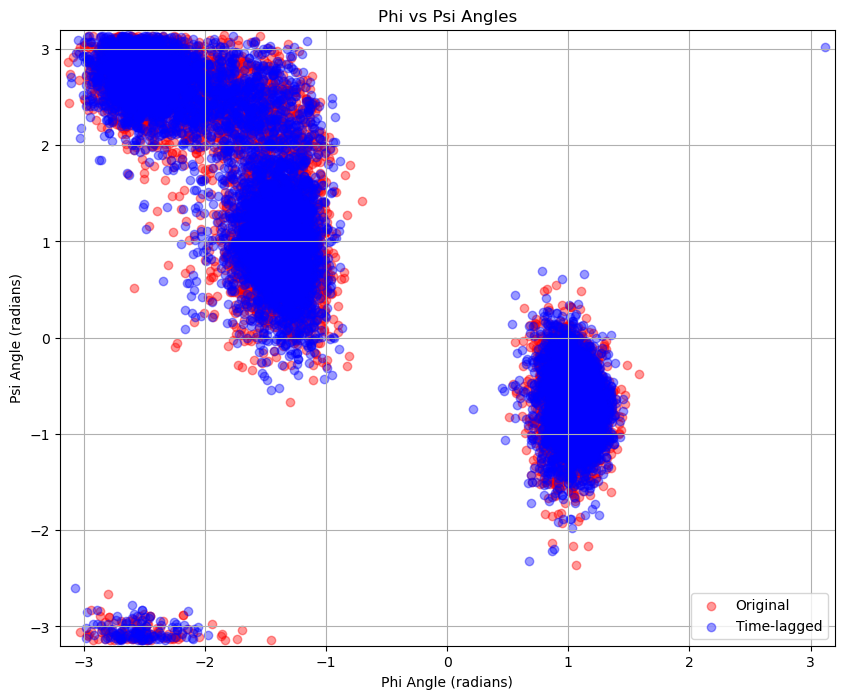

In [27]:
index = -1
plt.figure(figsize=(10, 8))
plt.scatter(phi[:index], psi[:index], c='red', label='Original', alpha=0.4)
plt.scatter(phi_timelag[:index], psi_timelag[:index], c='blue', label='Time-lagged', alpha=0.4)
plt.xlabel('Phi Angle (radians)')
plt.ylabel('Psi Angle (radians)')
plt.xlim(-3.2, 3.2)
plt.ylim(-3.2, 3.2)
plt.title('Phi vs Psi Angles')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
topology = md.load(f"../data/{molecule}/{state}.pdb").topology
traj = md.Trajectory(
    xyz_aligned.numpy(),
    topology
)
nv.show_mdtraj(traj)

NGLWidget(max_frame=9999)

In [68]:
topology = md.load(f"../data/{molecule}/{state}.pdb").topology
traj = md.Trajectory(
    xyz_aligned_timelag.numpy(),
    topology
)
nv.show_mdtraj(traj)

NGLWidget(max_frame=9999)

# Labels

In [10]:
dataset = torch.load(f"../dataset/{molecule}/{temperature}/{version}/xyz-aligned.pt")
label = torch.load(f"../dataset/{molecule}/{temperature}/{version}/label.pt")
phi = np.load(f"../dataset/{molecule}/{temperature}/{version}/phi.npy")
psi = np.load(f"../dataset/{molecule}/{temperature}/{version}/psi.npy")
print(dataset.shape, label.shape, phi.shape, psi.shape)

torch.Size([10000, 22, 3]) torch.Size([10000]) (10000, 1) (10000, 1)


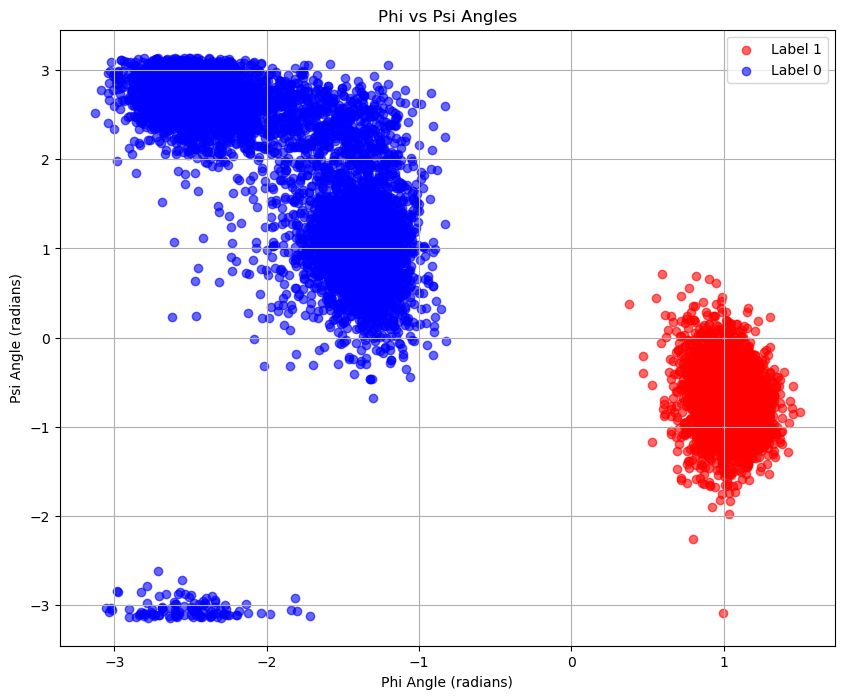

In [ ]:
# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(phi[label == 1], psi[label == 1], c='red', label='Label 1', alpha=0.6)
plt.scatter(phi[label != 1], psi[label != 1], c='blue', label='Label 0', alpha=0.6)
plt.xlabel('Phi Angle (radians)')
plt.ylabel('Psi Angle (radians)')
plt.title('Phi vs Psi Angles')
plt.legend()
plt.grid(True)
plt.show()

# Distance

In [51]:
dataset = torch.load(f"../dataset/{molecule}/{temperature}/{version}/cl-distance.pt")

### Load dataset

In [52]:
state_list = []
positive_list = []
negative_list = []

for data in tqdm(dataset):
	current_state, positive, negative, _, _ = data
	state_list.append(current_state)
	positive_list.append(positive)
	negative_list.append(negative)

  0%|          | 0/4000000 [00:00<?, ?it/s]

In [53]:
state_list = np.stack(state_list)
positive_list = np.stack(positive_list)
negative_list = np.stack(negative_list)

print(state_list.shape, positive_list.shape, negative_list.shape)

(4000000, 45) (4000000, 45) (4000000, 45)


### Visualization

<Figure size 640x480 with 0 Axes>

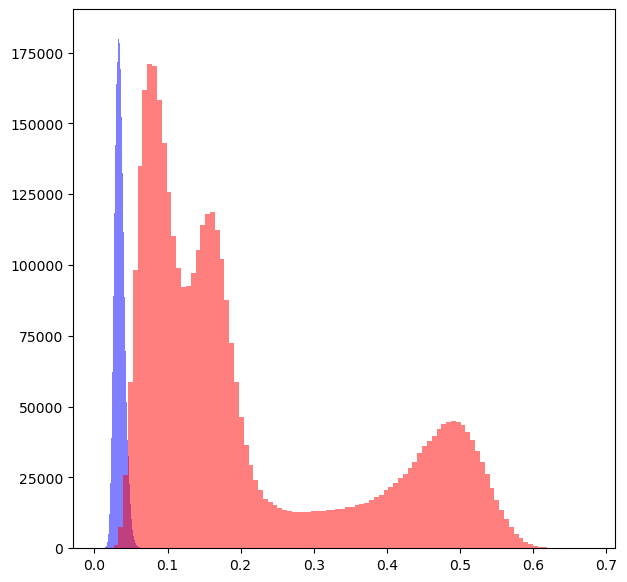

In [54]:
positive_distance_list = np.linalg.norm(positive_list - state_list, axis=1)
negative_distance_list = np.linalg.norm(negative_list - state_list, axis=1)

plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.hist(positive_distance_list, bins=100, alpha=0.5, color="blue", label="Positive")
ax.hist(negative_distance_list, bins=100, alpha=0.5, color="red", label="Negative")
plt.show()